## Discovering nonlinear heat equation with temperature dependent thermal conductivity from data using a set of parametric basis functions

In [22]:
# Import required libraried
import numpy as np
import jax.numpy as jnp
import jax
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
from matplotlib.pyplot import cm

jax.config.update("jax_enable_x64", True)

import PDE_FIND
import optimal_sindy_pde
import importlib
importlib.reload(PDE_FIND)
importlib.reload(optimal_sindy_pde)
from PDE_FIND import build_linear_system, print_pde
from optimal_sindy_pde import OptimalPDESINDy

In [23]:
# Importing the data of nonlinear heat equation

data = sio.loadmat('C:/Users/tabis/Desktop/PhD_second_year/Koopman_gradient_optimization/SINDy_experiments/PDE_FIND/Data/heat_nonlinear_1d_data.mat') # enter the path of the data generated by pde_dataset_generator file
u = np.real(data['usol'])
x = np.real(data['x'][0])
t = np.real(data['t'][0,:])
dt = t[1]-t[0]
dx = x[2]-x[1]

Text(0.5, 0.5, 't')

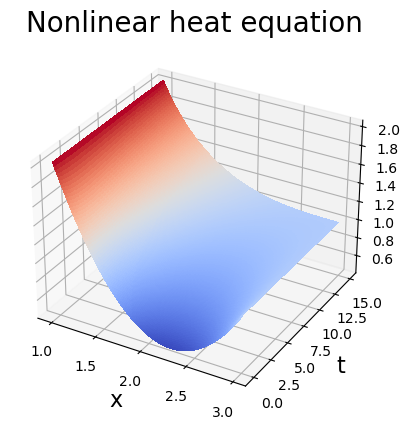

In [24]:
# Plotting the surface

X, T = np.meshgrid(x, t)
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
plt.title('Nonlinear heat equation', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('t', fontsize = 16)

In [25]:
# Build the linear system for regression and description of right hand side

Ut, R, rhs_des = build_linear_system(u, dt, dx, D=2, P=2, time_diff = 'FD', space_diff = 'FD')
rhs_des = ['1'] + rhs_des[1:]         # add 1 to the description

In [26]:
# Create a new description including the nonlinear coefficient terms

rhs_des_n = rhs_des.copy()
uxx_ind = rhs_des.index('u_{xx}')
rhs_des_n.append('exp(Xu)u_{x}^2')
rhs_des_n.append('exp(Xu)u_{xx}')
rhs_des_n

['1',
 'u',
 'u^2',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'exp(Xu)u_{x}^2',
 'exp(Xu)u_{xx}']

In [113]:
# initializing the parameters for optimization algorithms

w_init = jnp.zeros((len(rhs_des_n), 1))                      # Initial coefficients vector 
p_init = jnp.array([-3.0])                                    # Initial parameter of the nonlinear term
epss = 0.5                                                  # Approximation tolerance
loops = 500                                                  # Number of iterations
theta = R                                                    # Data matrix for dictionary 
rhs_des = rhs_des                                            # Description of rhs
Ut = Ut                                                      # Ut column vector
lam = 1e-5                                                     # regularization penalty  

opt_heat_pde = OptimalPDESINDy(epss, loops, rhs_des)

# For step size

D = R.T @ R                                
e = np.linalg.eig(D)                            
L = np.max(e[0])                               
hw = np.real(1/L)
hp = hw
print(hw)

5.905608009658032e-07


## Optimization algorithms implementation

In [114]:
# Adam

w_adam, p_adam, f_vals_adam, f_vals_adam_p, p_vals = opt_heat_pde.adam(w_init, p_init, theta, Ut, lam, hw=0.15, hp=0.15)

#w_adam, p_adam, f_vals_adam, f_vals_adam_p, p_vals = opt_heat_pde.adam_decay(w_init, p_init, theta, Ut, lam, hw=0.08, hp=0.08, decay_rate=1, decay_steps=1)

In [115]:
# The value of discovered parameter chi which is p in the code
print(p_adam)

[-1.09484323]


In [116]:
w_adam

Array([[ 2.43822665e-03],
       [-7.90073061e-04],
       [ 1.77771931e-05],
       [-4.61598342e-03],
       [ 2.45406624e-04],
       [ 2.28168794e-03],
       [ 0.00000000e+00],
       [ 7.30524195e-04],
       [ 2.60487862e-04],
       [-1.14290555e-01],
       [ 1.05445251e-01]], dtype=float64)

In [117]:
# Print the discovered PDE after doing iterative hard thresholding of values below 0.04 
print_pde(w_adam, rhs_des_n)

u_t = (-0.114291 +0.000000i)exp(Xu)u_{x}^2
    + (0.105445 +0.000000i)exp(Xu)u_{xx}
   


In [121]:
##  Visualizing energy surface
p_array = np.concatenate([np.array(p_vals).flatten(), np.linspace(-1.1, -0.1, 40)])
cost_pde = np.zeros(len(p_array))

for i in range(len(p_array)):
    R_n_exp = opt_heat_pde.build_new_theta(p_array[i], R)
    #w = TrainSTRidge(R_n_exp, Ut, 1e-5, 0.8)
    w_exp = opt_heat_pde.pde_sindy(R_n_exp, Ut, lam=1e-9)
    c = opt_heat_pde.cost_pde_sindy(w_exp, p_array[i], R, Ut, lam=1e-3)
    cost_pde[i] = c


# for i in range(len(list_chi)):
#     R_n_exp = opt_heat_pde.build_new_theta(list_chi[i], R)
#     #w = TrainSTRidge(R_n_exp, Ut, 1e-5, 0.8)
#     w_exp = opt_heat_pde.pde_sindy(R_n_exp, Ut, lam=1e-9)
#     s = opt_heat_pde.cost_pde_sindy(w_exp, list_chi[i], R, Ut, lam=1e-3)
#     cost_pde.append(s) 


In [122]:
LAST = np.array(p_vals).flatten()[-1]
sep = p_array <= LAST
sep

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

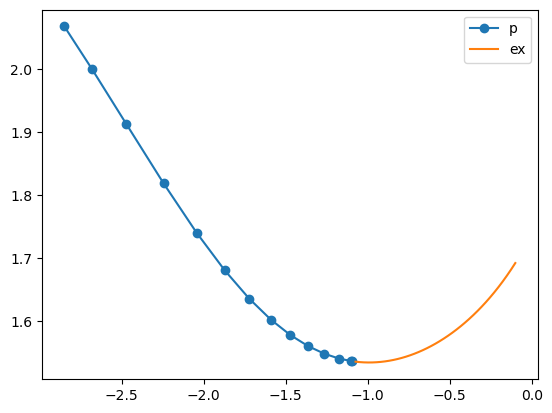

In [123]:
# Plot
plt.figure()
plt.plot(p_array[sep], cost_pde[sep], 'o-', label="p")
plt.plot(p_array[~sep], cost_pde[~sep], label="ex")

plt.legend()
plt.show()

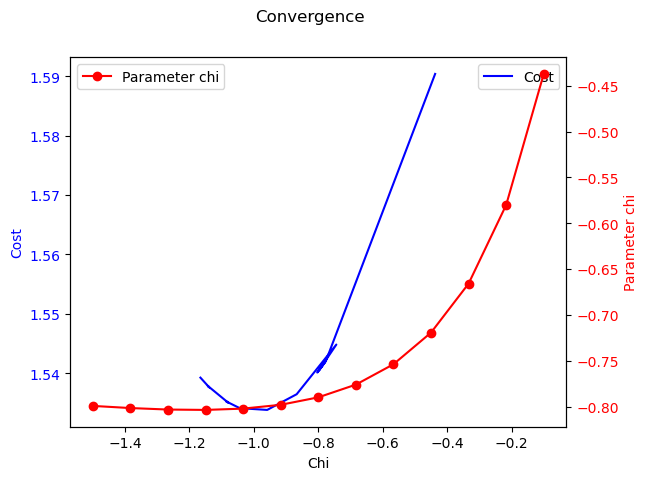

In [38]:
# Create figure and dual axes
fig, ax1 = plt.subplots()

# Plot cost values on the primary y-axis
ax1.plot(list_chi, cost_pde, 'b-', label="Cost")
ax1.set_xlabel("Chi")
ax1.set_ylabel("Cost", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a secondary y-axis for x-values
list_p = np.linspace(-0.1, -1.5, 13)
ax2 = ax1.twinx()
ax2.plot(list_p, p_vals[:50:4], 'r-o', label="Parameter chi")
ax2.set_ylabel("Parameter chi", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Add a title and legend
fig.suptitle("Convergence")
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")

plt.show()

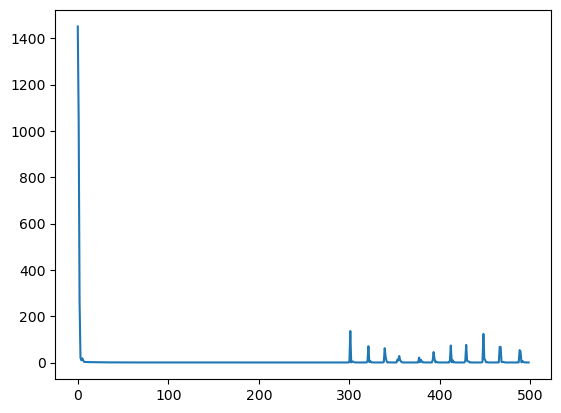

In [39]:
plt.plot(f_vals_adam_p)

In [74]:
# Solve with STRidge from PDE_FIND algorithm for different values of parameter p

R_n = opt_heat_pde.build_new_theta(-0.0, R)
w = TrainSTRidge(R_n, Ut, 1e-2, 0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des_n)

C:\Users\tabis\Desktop\PhD_second_year\Koopman_gradient_optimization\SINDy_experiments\PDE_FIND\SINDy_PDE_FIND.py:580: RuntimeWarning: divide by zero encountered in scalar divide
  Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))


LinAlgError: SVD did not converge in Linear Least Squares